# Set up Data Frames

In [17]:
# Import modules

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [18]:
# Dataset 1 is R&D data from Kaggle
ip = pd.read_csv("data/Top 2000 RD Companies.csv", sep=",")
ip.rename(columns={"Top 2000 R&D rank":"rank", "Company name":"company", "Company's headquarter location":"hq_country", "Industry":"industry", "R&D expenditures Share":"rdspend_share", "Patents Share":"patent_share", "Trademarks Share":"trademark_share"}, inplace=True)


In [19]:
ip.head()

,rank,company,hq_country,industry,rdspend_share,patent_share,trademark_share
0,1,ALPHABET,United States,IT services,2.269,0.553,0.431
1,2,SAMSUNG ELECTRONICS,Korea,Computers & electronics,1.842,3.634,1.157
2,3,MICROSOFT,United States,Publishing & broadcasting,1.831,0.358,0.243
3,4,VOLKSWAGEN,Germany,Transport equipment,1.694,0.848,0.423
4,5,HUAWEI INVESTEMENT & HOLDING CO,China,Computers & electronics,1.582,1.703,0.801


# Analysis 1:  Country Analysis
## (a) Which countries host the greatest number of companies in the Top 2000 R&D ranks?
## (b) Which countries have the highest R&D expenditure share if we sum the companies in the Top 2000 R&D ranks?
## (c) Which countries have the highest patent share if we sum the companies in the Top 2000 R&D ranks?
## (d) How do these answers change if we normalize for population i.e. per capita figures?
## (e) Which countries have the highest efficiency of patent production per dollar expenditure given the Top 2000

In [20]:
# Set up data grouped by country
country_group = ip.groupby("hq_country")

# Apply aggregates
colFun = {'company':['count'],
          'rdspend_share':['sum'],
          'patent_share':['sum']}

country_analysis = country_group.agg(colFun)

# Rename columns
country_analysis = pd.DataFrame(country_analysis.to_records())  # flatten hierarchical index
country_analysis.columns = ["hq_country", "num_cos", "rd_share", "patent_share"]

In [21]:
# Dataset 2 is population data which will be used for per cap calculations
pop = pd.read_csv("data/population.csv", sep=",", usecols = ["Country", "Population"])
pop.rename(columns={"Country":"hq_country", "Population":"pop"}, inplace = True)

# Merge datasets
country_analysis = pd.merge(left=country_analysis, right=pop, on="hq_country", how="left")

# Add population share
total_pop = pop['pop'].sum()
country_analysis['pop_share'] = country_analysis['pop']/total_pop

country_analysis.head()


,hq_country,num_cos,rd_share,patent_share,pop,pop_share
0,Argentina,1,0.009,0.000,45195774,0.010105
1,Australia,11,0.350,0.063,25499884,0.005701
2,Austria,13,0.184,0.242,9006398,0.002014
3,Belgium,11,0.330,0.177,11589623,0.002591
4,Brazil,6,0.126,0.030,212559417,0.047525


In [22]:
# Set up per capita calculations
country_analysis['num_co_per_mpop'] = country_analysis['num_cos']/(country_analysis['pop']/1e6)

country_analysis['rd_share_to_pop_share'] = country_analysis['rd_share']/country_analysis['pop_share']
country_analysis['rank_rd_pop'] = country_analysis['rd_share_to_pop_share'].rank(ascending=False)

country_analysis['patent_share_to_pop_share'] = country_analysis['patent_share']/country_analysis['pop_share']
country_analysis['rank_patent_pop'] = country_analysis['patent_share_to_pop_share'].rank(ascending=False)

country_analysis.head()

,hq_country,num_cos,rd_share,patent_share,pop,pop_share,num_co_per_mpop,rd_share_to_pop_share,rank_rd_pop,patent_share_to_pop_share,rank_patent_pop
0,Argentina,1,0.009,0.000,45195774,0.010105,0.022126,0.890651,36.0,0.000000,37.5
1,Australia,11,0.350,0.063,25499884,0.005701,0.431375,61.389293,22.0,11.050073,29.0
2,Austria,13,0.184,0.242,9006398,0.002014,1.443418,91.375439,20.0,120.178567,16.0
3,Belgium,11,0.330,0.177,11589623,0.002591,0.949125,127.352484,18.0,68.307241,18.0
4,Brazil,6,0.126,0.030,212559417,0.047525,0.028227,2.651264,33.0,0.631253,32.0


In [23]:
# Calculate efficiency
country_analysis['patent_eff'] = country_analysis['patent_share']/country_analysis['rd_share']
country_analysis['rank_patent_eff'] = country_analysis['patent_eff'].rank(ascending=False)

country_analysis

,hq_country,num_cos,rd_share,patent_share,pop,pop_share,num_co_per_mpop,rd_share_to_pop_share,rank_rd_pop,patent_share_to_pop_share,rank_patent_pop,patent_eff,rank_patent_eff
0,Argentina,1,0.009,0.000,45195774,0.010105,0.022126,0.890651,36.0,0.000000,37.5,0.000000,37.5
1,Australia,11,0.350,0.063,25499884,0.005701,0.431375,61.389293,22.0,11.050073,29.0,0.180000,33.0
2,Austria,13,0.184,0.242,9006398,0.002014,1.443418,91.375439,20.0,120.178567,16.0,1.315217,7.0
3,Belgium,11,0.330,0.177,11589623,0.002591,0.949125,127.352484,18.0,68.307241,18.0,0.536364,21.0
4,Brazil,6,0.126,0.030,212559417,0.047525,0.028227,2.651264,33.0,0.631253,32.0,0.238095,31.0
5,Canada,21,0.543,0.222,37742154,0.008438,0.556407,64.348131,21.0,26.308076,21.0,0.408840,25.0
6,China,365,11.346,8.116,1439323776,0.321807,0.253591,35.257139,27.0,25.220072,22.0,0.715318,18.0
7,Chinese Taipei,64,1.901,3.904,23816775,0.005325,2.687182,356.994851,12.0,733.144607,6.0,2.053656,3.0
8,Denmark,25,0.702,0.312,5792202,0.001295,4.316148,542.071035,7.0,240.920460,13.0,0.444444,23.0
9,Finland,15,0.653,0.512,5540720,0.001239,2.707229,527.120330,8.0,413.301086,10.0,0.784074,16.0


Text(0, 0.5, 'number of companies')

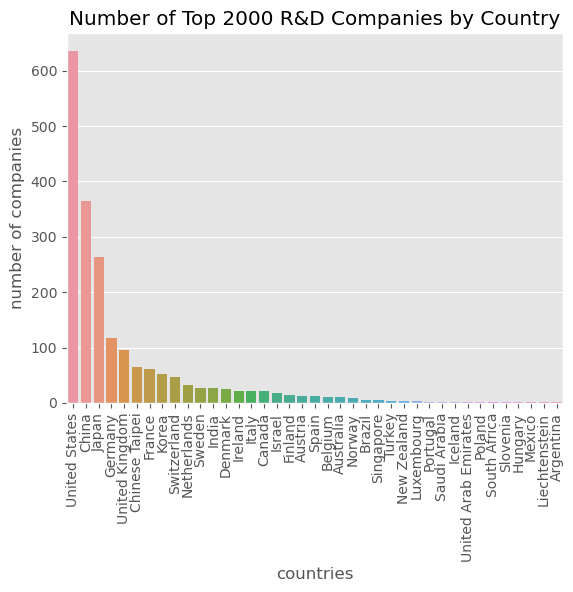

In [50]:
# (a) Which countries host the greatest number of companies in the Top 2000 R&D ranks?

# Barplot
# country_analysis[['hq_country','num_cos']].plot.bar(x = 'hq_country', color = 'b')
# plt.title('Number of Top 2000 R&D Companies by Country')
# plt.xlabel('countries')
# plt.ylabel('number companies')
# plt.legend(['number of companies'])

sns.barplot(x = 'hq_country',
            y = 'num_cos',
            data = country_analysis,
            order = country_analysis.sort_values('num_cos', ascending = False).hq_country)
plt.xticks(rotation=90)
plt.title('Number of Top 2000 R&D Companies by Country')
plt.xlabel('countries')
plt.ylabel('number of companies')


Text(0, 0.5, 'share of R&D expenditure')

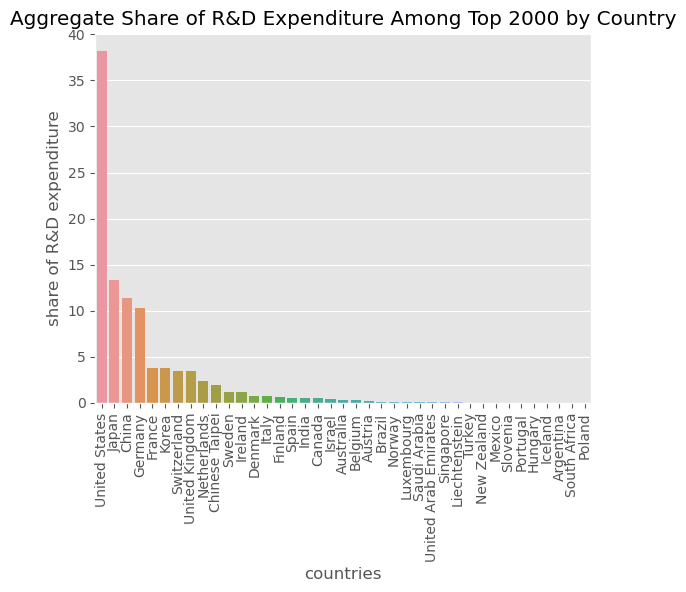

In [51]:
# (b) Which countries have the highest R&D expenditure share if we sum the companies in the Top 2000 R&D ranks?

sns.barplot(x = 'hq_country',
            y = 'rd_share',
            data = country_analysis,
            order = country_analysis.sort_values('rd_share', ascending = False).hq_country)
plt.xticks(rotation=90)
plt.title('Aggregate Share of R&D Expenditure Among Top 2000 by Country')
plt.xlabel('countries')
plt.ylabel('share of R&D expenditure')


Text(0, 0.5, 'share of patents')

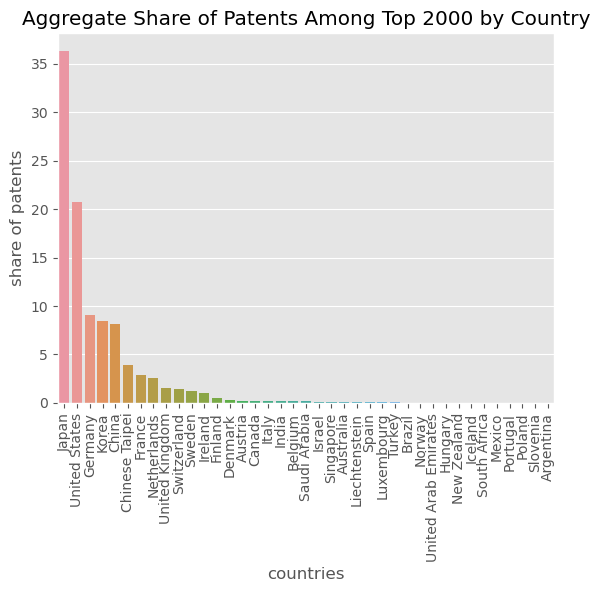

In [52]:
# (c) Which countries have the highest patent share if we sum the companies in the Top 2000 R&D ranks?

sns.barplot(x = 'hq_country',
            y = 'patent_share',
            data = country_analysis,
            order = country_analysis.sort_values('patent_share', ascending = False).hq_country)
plt.xticks(rotation=90)
plt.title('Aggregate Share of Patents Among Top 2000 by Country')
plt.xlabel('countries')
plt.ylabel('share of patents')

Text(0, 0.5, 'number of companies per million people')

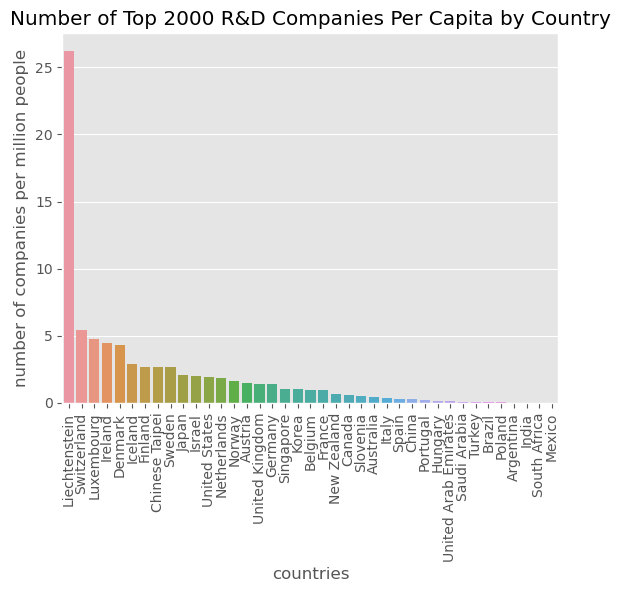

In [55]:
# (d) How do these answers change if we normalize for population i.e. per capita figures?

# Number of Top 2000 R&D Companies Per Capita by Country

sns.barplot(x = 'hq_country',
            y = 'num_co_per_mpop',
            data = country_analysis,
            order = country_analysis.sort_values('num_co_per_mpop', ascending = False).hq_country)
plt.xticks(rotation=90)
plt.title('Number of Top 2000 R&D Companies Per Capita by Country')
plt.xlabel('countries')
plt.ylabel('number of companies per million people')


Text(0, 0.5, 'share of R&D expenditure to share of pop')

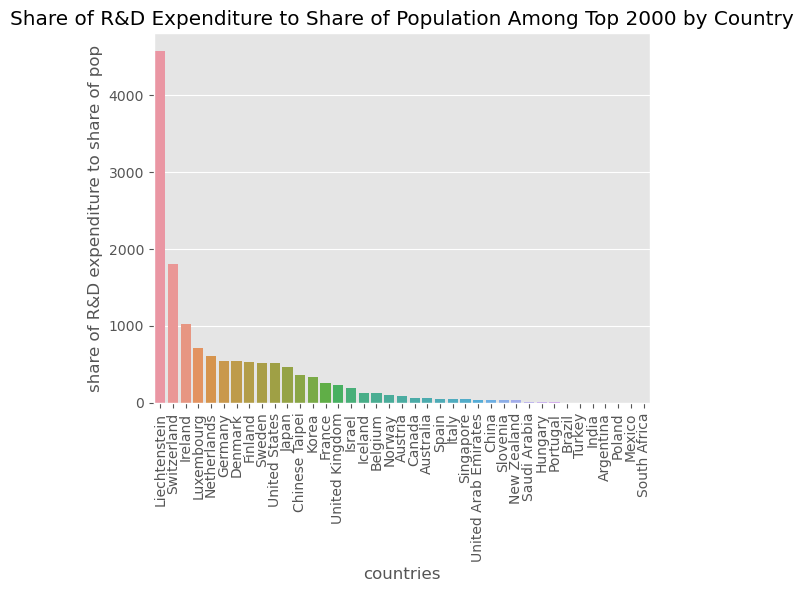

In [58]:
# (d) cont.

# Share of R&D Expenditure to Share of Population Among Top 2000 by Country

sns.barplot(x = 'hq_country',
            y = 'rd_share_to_pop_share',
            data = country_analysis,
            order = country_analysis.sort_values('rd_share_to_pop_share', ascending = False).hq_country)
plt.xticks(rotation=90)
plt.title('Share of R&D Expenditure to Share of Population Among Top 2000 by Country')
plt.xlabel('countries')
plt.ylabel('share of R&D expenditure to share of pop')


Text(0, 0.5, 'share of patents to share of pop')

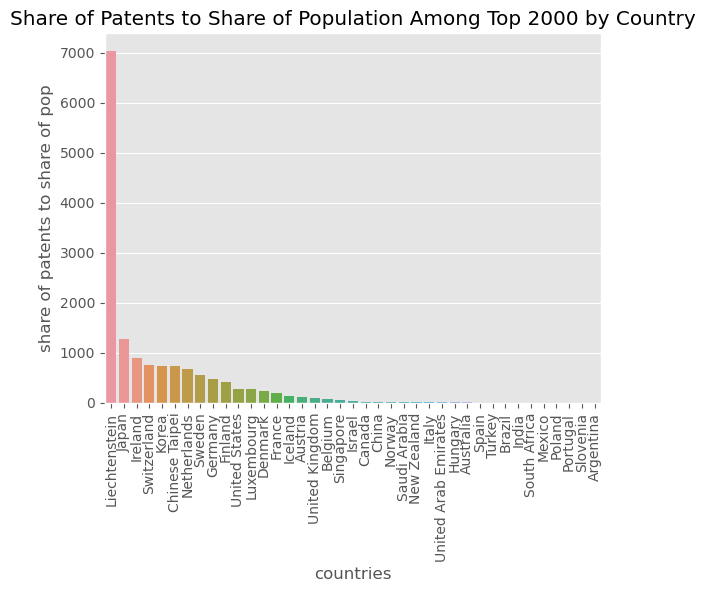

In [61]:
# (d) cont.

# Share of Patent Expenditure to Share of Population Among Top 2000 by Country

sns.barplot(x = 'hq_country',
            y = 'patent_share_to_pop_share',
            data = country_analysis,
            order = country_analysis.sort_values('patent_share_to_pop_share', ascending = False).hq_country)
plt.xticks(rotation=90)
plt.title('Share of Patents to Share of Population Among Top 2000 by Country')
plt.xlabel('countries')
plt.ylabel('share of patents to share of pop')

Text(0, 0.5, 'share of patents to share of R&D expenditure')

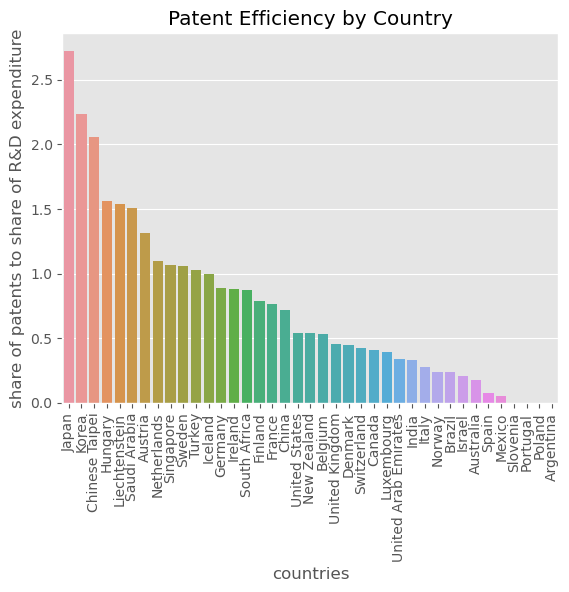

In [60]:
# (e) Which countries have the highest efficiency of patent production per dollar expenditure given the Top 2000

# Share of Patent to Share of Population Among Top 2000 by Country

sns.barplot(x = 'hq_country',
            y = 'patent_eff',
            data = country_analysis,
            order = country_analysis.sort_values('patent_eff', ascending = False).hq_country)
plt.xticks(rotation=90)
plt.title('Patent Efficiency by Country')
plt.xlabel('countries')
plt.ylabel('share of patents to share of R&D expenditure')


In [ ]:
# POTENTIAL ANALYSIS: What happens if we exclude Netherlands, Luxembourg, Ireland, Singapore, Lichtenstein?
# https://en.wikipedia.org/wiki/Tax_haven#Top_10_tax_havens

In [ ]:
# POTENTIAL ANALYSIS: Company by country data
# 

# Analysis 2:  Industry Analysis
## (a) Which industries host the greatest number of companies in the Top 2000 R&D ranks?
## (b) Which industries have the highest R&D expenditure share if we sum the companies in the Top 2000 R&D ranks?
## (c) Which industries have the highest patent share if we sum the companies in the Top 2000 R&D ranks?
## (d) Which industries have the highest efficiency of patent production per dollar expenditure given the Top 2000

In [8]:
# Set up data grouped by industry
industry_group = ip.groupby("industry")

# Apply aggregates (Part a-c)
colFun = {'industry':['count'],
          'rdspend_share':['sum'],
          'patent_share':['sum']}

industry_analysis = industry_group.agg(colFun)

# Rename columns
industry_analysis = pd.DataFrame(industry_analysis.to_records())  # flatten hierarchical index
industry_analysis.columns = ["industry", "num_cos", "rd_share", "patent_share"]

In [9]:
industry_analysis.head()

,industry,num_cos,rd_share,patent_share
0,Admin & support services,16,0.534,0.119
1,Agriculture,5,0.095,0.014
2,Arts & entertainment,3,0.080,0.061
3,Basic metals,83,1.555,3.543
4,Chemicals,127,3.603,7.152


In [10]:
# Calculate patent efficiency (Part d)
industry_analysis['patent_eff'] = industry_analysis['patent_share']/industry_analysis['rd_share']
industry_analysis['rank_patent_eff'] = industry_analysis['patent_eff'].rank(ascending=False)


In [11]:
industry_analysis


,industry,num_cos,rd_share,patent_share,patent_eff,rank_patent_eff
0,Admin & support services,16,0.534,0.119,0.222846,24.0
1,Agriculture,5,0.095,0.014,0.147368,29.0
2,Arts & entertainment,3,0.080,0.061,0.762500,15.0
3,Basic metals,83,1.555,3.543,2.278457,3.0
4,Chemicals,127,3.603,7.152,1.985012,5.0
5,Coke & petroleum,14,0.314,0.350,1.114650,8.0
6,Computers & electronics,361,22.805,34.991,1.534357,7.0
7,Construction,23,1.430,0.251,0.175524,26.0
8,Education,2,0.019,0.000,0.000000,32.5
9,Electrical equipment,60,2.726,6.379,2.340059,2.0


# Analysis 3:  Company Analysis
## (a) Which companies have the highest patent share of the top 2000?
## (b) Which companies have the highest efficiency of patent production per dollar expenditure within the top 2000?
## (c) Which companies are best and worst in their industry by patent share?
## (d) Which companies are best and worst in their industry by patent efficiency?

In [12]:
# Set up the raw data
company_analysis = ip

# Calculate ranks for R&D expenditure share, patent share, and trademark share
company_analysis['rank_rdspend_share'] = company_analysis['rdspend_share'].rank(ascending=False)
company_analysis['rank_patent_share'] = company_analysis['patent_share'].rank(ascending=False)
company_analysis['rank_trademark_share'] = company_analysis['trademark_share'].rank(ascending=False)

# Calculate patent efficiency
company_analysis['patent_eff'] = company_analysis['patent_share']/company_analysis['rdspend_share']
company_analysis['rank_patent_eff'] = company_analysis['patent_eff'].rank(ascending=False)


In [63]:
# Sort by patent share (Part a)

company_analysis.sort_values("rank_patent_share",ascending = True).head(20)

,rank,company,hq_country,industry,rdspend_share,patent_share,trademark_share,rank_rdspend_share,rank_patent_share,rank_trademark_share,patent_eff,rank_patent_eff
1,2,SAMSUNG ELECTRONICS,Korea,Computers & electronics,1.842,3.634,1.157,2.0,1.0,7.0,1.972856,334.0
58,59,CANON,Japan,Machinery,0.309,2.496,0.137,59.0,2.0,169.0,8.077670,42.0
4,5,HUAWEI INVESTEMENT & HOLDING CO,China,Computers & electronics,1.582,1.703,0.801,5.0,3.0,13.0,1.076485,560.0
186,187,BOE TECHNOLOGY GROUP,China,Computers & electronics,0.104,1.608,0.018,187.0,4.0,781.0,15.461538,13.0
14,15,FORD MOTOR,United States,Transport equipment,0.890,1.544,0.126,15.0,5.0,186.0,1.734831,379.0
19,20,ROBERT BOSCH,Germany,Machinery,0.769,1.518,0.377,20.0,6.0,55.0,1.973992,333.0
31,32,PANASONIC,Japan,Electrical equipment,0.529,1.441,0.813,32.0,7.0,12.0,2.724008,227.0
64,65,UNITED TECHNOLOGIES,United States,Transport equipment,0.267,1.373,0.135,65.0,8.0,173.5,5.142322,89.0
151,152,SUMITOMO ELECTRIC,Japan,Basic metals,0.127,1.361,0.116,152.0,9.0,201.5,10.716535,25.0
57,58,HITACHI,Japan,Electrical equipment,0.316,1.268,0.433,58.0,10.0,44.0,4.012658,124.0


In [64]:
# Sort by patent efficiency (Part b)

company_analysis.sort_values("rank_patent_eff",ascending = True).head(20)

,rank,company,hq_country,industry,rdspend_share,patent_share,trademark_share,rank_rdspend_share,rank_patent_share,rank_trademark_share,patent_eff,rank_patent_eff
941,942,DENKA,Japan,Chemicals,0.014,0.725,0.120,955.0,27.0,196.5,51.785714,1.0
1976,1977,SHANGHAI PRIME MACHINERY,China,Machinery,0.005,0.253,0.007,1986.0,90.5,1116.5,50.600000,2.0
1575,1576,SEIKAGAKU,Japan,Pharmaceuticals,0.007,0.291,0.039,1630.0,76.0,494.0,41.571429,3.0
1582,1583,CASIO COMPUTER,Japan,Computers & electronics,0.007,0.189,0.077,1630.0,117.0,296.5,27.000000,4.0
375,376,TOYOTA INDUSTRIES,Japan,Transport equipment,0.043,0.886,0.030,374.0,21.0,593.5,20.604651,5.0
1248,1249,TIANMA MICROELECTRONICS,China,Computers & electronics,0.010,0.194,0.010,1251.0,113.5,995.5,19.400000,6.0
1418,1419,KOLON,Korea,Chemicals,0.008,0.145,0.021,1476.0,156.0,731.5,18.125000,7.0
915,916,JAPAN DISPLAY,Japan,Computers & electronics,0.015,0.270,0.000,906.0,86.0,1817.5,18.000000,8.0
296,297,SEIKO EPSON,Japan,Computers & electronics,0.057,0.952,0.037,298.0,19.0,514.0,16.701754,9.0
1926,1927,LS,Korea,Basic metals,0.006,0.098,0.012,1841.5,207.5,941.0,16.333333,10.5


In [15]:
# Sort by industry by company for patent share (Part C)

ind_co_1 = pd.DataFrame().assign(company=company_analysis['company'], 
                               industry=company_analysis['industry'],
                               rank_patent_share=company_analysis['rank_patent_share']
                              )

ind_co_1 = ind_co_1.sort_values(["rank_patent_share"], ascending=True).groupby("industry")

for key, values in ind_co_1:
    print(key)
    print("-"*70)
    print(values)
    print("\n")

Admin & support services
----------------------------------------------------------------------
                        company                  industry  rank_patent_share
1536               INTERDIGITAL  Admin & support services              219.0
1853                   ALLEGION  Admin & support services              820.0
141                     NETFLIX  Admin & support services              855.0
200                     SERVIER  Admin & support services             1042.0
1784                KYMAB GROUP  Admin & support services             1115.5
1587                      SECOM  Admin & support services             1351.0
780                        EYGS  Admin & support services             1351.0
819                    EXPERIAN  Admin & support services             1714.5
753    TONGCHENG-ELONG HOLDINGS  Admin & support services             1714.5
440   ZHEJIANG DAHUA TECHNOLOGY  Admin & support services             1714.5
125     CTRIP.COM INTERNATIONAL  Admin & support services

In [16]:
# Sort by industry by company for patent share (Part D)

ind_co_2 = pd.DataFrame().assign(company=company_analysis['company'], 
                               industry=company_analysis['industry'],
                               rank_patent_eff=company_analysis['rank_patent_eff']
                              )

ind_co_2 = ind_co_2.sort_values(["rank_patent_eff"], ascending=True).groupby("industry")

for key, values in ind_co_2:
    print(key)
    print("-"*70)
    print(values)
    print("\n")

Admin & support services
----------------------------------------------------------------------
                        company                  industry  rank_patent_eff
1536               INTERDIGITAL  Admin & support services             20.0
1853                   ALLEGION  Admin & support services            445.0
1784                KYMAB GROUP  Admin & support services            825.5
1587                      SECOM  Admin & support services           1181.5
141                     NETFLIX  Admin & support services           1368.0
780                        EYGS  Admin & support services           1376.0
200                     SERVIER  Admin & support services           1395.0
440   ZHEJIANG DAHUA TECHNOLOGY  Admin & support services           1714.5
1897   BEIJING ORIENT LANDSCAPE  Admin & support services           1714.5
1890                 EVENTBRITE  Admin & support services           1714.5
125     CTRIP.COM INTERNATIONAL  Admin & support services           1714.5
1334

In [ ]:
# POTENTIAL ANALYSIS: How does FANGNAM compare?